# Full-FORCE demonstration
Eli Pollock, Jazayeri Lab, MIT Brain and Cognitive Sciences

The following demonstration is based on the full-FORCE algorithm described in [DePasquale et al. 2018](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0191527)

Thanks to Brian DePasquale for providing example code. For MATLAB demo, see [https://github.com/briandepasquale/full-FORCE-demos/tree/master/Matlab]. 

First, we create a function that will output our desired inputs, targets, and hints:

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import joblib
from tqdm import tnrange
sns.set(palette="deep", style="darkgrid")

Below, we can train and test the network using the FF_Demo module. The key component is the RNN object class, which has activity and weights as attributes as methods that allow for training, running, and testing the network on arbitrary tasks. Open up the module file to see how RLS is implemented.

Here, I create a parameter dictionary, hand-tune some of them, instantiate an RNN, train it with full-FORCE, and then test it. You can see where the algorithm spends most of its time with %lprun. It should only take a couple of minutes to get good training results.

Note that FF_Demo requires numpy, scipy, and matplotlib, but that's it! 

<IPython.core.display.Javascript object>


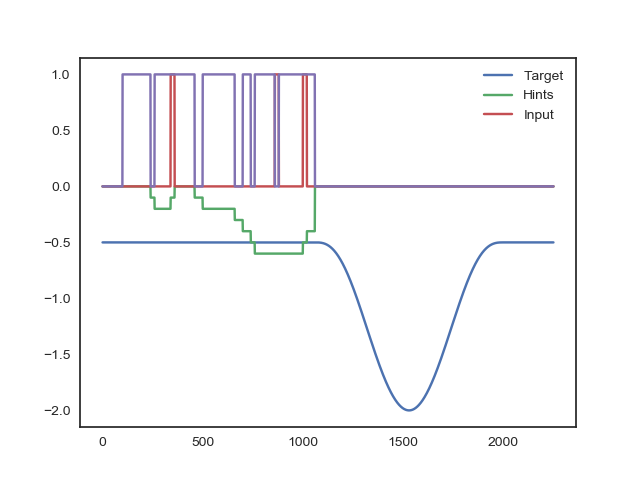

In [17]:
import FF_Demo
from trials import fullforce_poisson_clicks

fullforce_poisson_clicks(dt=0.001,showplots=True);

In [25]:
p = FF_Demo.create_parameters(dt=0.001)
p['g'] = 1.5 # From paper
p['network_size'] = 1000
p['ff_num_batches'] = 50
p['ff_trials_per_batch'] = 0
p['ff_init_trials'] = 10
p['test_init_trials']=10
p['ff_steps_per_update'] = 1

rnn = FF_Demo.RNN(p,2,1)

In [ ]:
#rnn.train(fullforce_poisson_clicks, monitor_training=True)

In [4]:
# if not os.path.isdir('data'):
#     os.makedirs('data')
# fn=os.path.join('data', str(int(time.time())) +
#                 '_fullforce_poisson_rnn.p.z')
# joblib.dump(rnn, filename=fn, compress=3)

['data/fullforce_poisson_rnn.p.z']

In [3]:
rnn = joblib.load('data/fullforce_poisson_rnn.p.z')

<IPython.core.display.Javascript object>


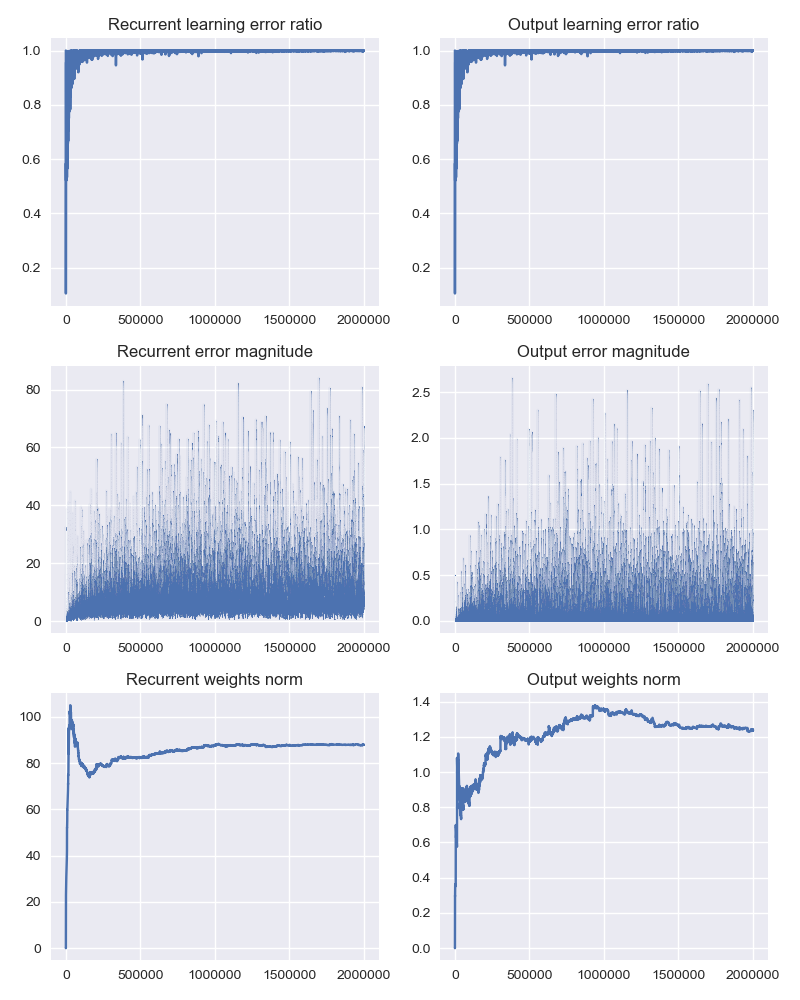

In [42]:
rnn.plot_training()

Initializing

<IPython.core.display.Javascript object>


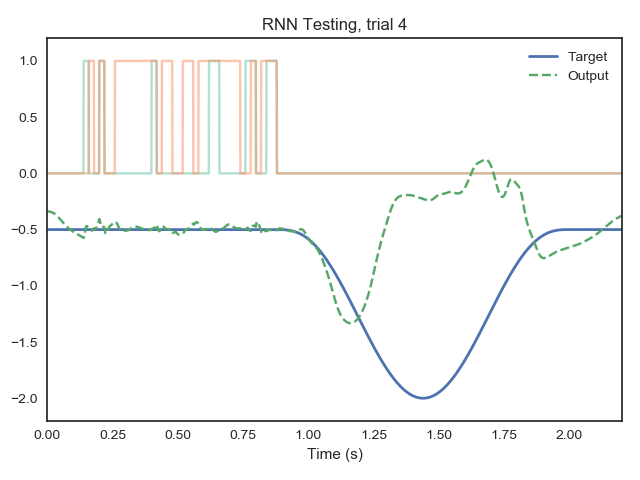

Testing: 5 trials


/Users/davidhbrann/anaconda2/envs/FORCE/lib/python3.6/site-packages/matplotlib/legend.py:938: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x1174b4390>, <matplotlib.lines.Line2D object at 0x1174b4518>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)



Normalized error: 0.448421


array([[ 0.44842118]])

In [19]:
rnn.p['test_trials'] = 5
rnn.test(fullforce_poisson_clicks)

In [47]:
inp, targ, = fullforce_poisson_clicks(dt=0.001)[:2]
nt = inp.shape[0]
N = 1000 # trials

inps = np.zeros((nt, inp.shape[1], N))
targs = np.zeros((nt, N))
L_all = np.zeros(N)
t_stims = np.zeros_like(L_all)

for i in tnrange(N):
    inps[:,:,i], targ, _, L_all[i], t_stims[i] = fullforce_poisson_clicks(dt=0.001)
    targs[:,i] = targ.ravel()
    
n_outputs = 20
outputs = rnn.test_batch(inps[:,:,:n_outputs], targs[:,:n_outputs],
                         norm_only=False, inps_and_targs=fullforce_poisson_clicks)


Initializing


Testing: 20 trials


<IPython.core.display.Javascript object>


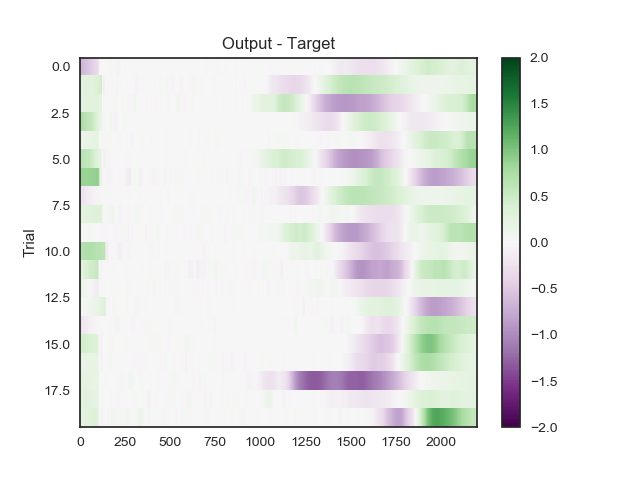

In [31]:
sns.set_style("white")
plt.figure()
plt.imshow((outputs - targs[:,:n_outputs]).T, aspect='auto', vmin=-2, vmax=2, cmap="PRGn")
plt.ylabel("Trial")
plt.title("Output - Target")
plt.colorbar();

## Look at eigenvalue spectra

In [44]:
def get_eig(rnn):
    J = np.transpose(rnn.rnn_par['rec_weights'])
    w,v = np.linalg.eig(J)
    return w

In [99]:
untrained_rnn = FF_Demo.RNN(p,2,1)
w_untrained = get_eig(untrained_rnn)
w = get_eig(rnn)

<IPython.core.display.Javascript object>


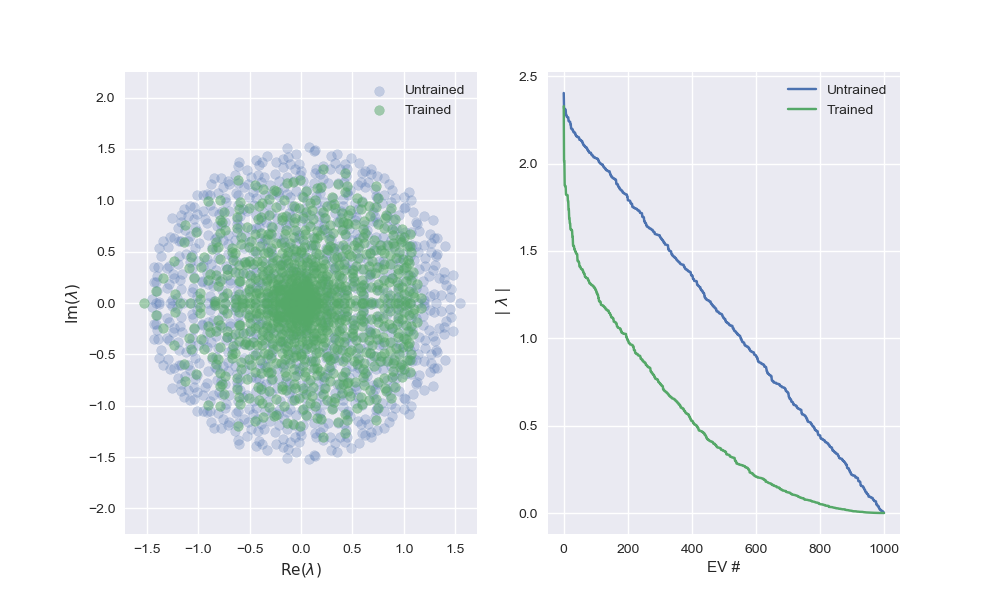

In [116]:
fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].scatter(w_untrained.real, w_untrained.imag, alpha=0.25, label="Untrained")
ax[0].scatter(w.real, w.imag, alpha=0.5, label="Trained")
ax[0].set_xlabel(r'$\mathrm{Re}(\lambda)}$')
ax[0].set_ylabel(r'$\mathrm{Im}(\lambda)}$')
ax[0].axis('equal')
ax[0].legend()

sort_w = lambda x: np.sort(x.real**2 + x.imag**2)[::-1]
ax[1].plot(sort_w(w_untrained), label="Untrained")
ax[1].plot(sort_w(w), label="Trained")
ax[1].set_xlabel('EV #')
ax[1].set_ylabel(r'$\mid\lambda\mid$')
ax[1].legend()

In [8]:
# %load_ext line_profiler
# %lprun -f rnn.train rnn.train(fullforce_oscillation_test, monitor_training=1)

The training statistics include an "error ratio" that is the ratio of the error after the update to the error before the update. It should converge to 1, meaning that the network cannot do any better.

The error magnitude is the just the norm of the error. That should decrease to close to 0.

The weights norm is, as one would expect, the norm of all weights. That should converge on some constant value as the weights stabilize.